In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import upsetplot
from functools import reduce
import warnings
warnings.filterwarnings('ignore')


In [21]:
## Data loading

In [2]:
ll

total 48
drwxrwxr-x 24 priesgo 4096 Jun  8 06:57 condaenv/
drwxrwxr-x  2 priesgo 4096 Jun  8 06:54 ERR5229917/
drwxrwxr-x  2 priesgo 4096 Jun  8 06:54 ERR5397623/
drwxrwxr-x  2 priesgo 4096 Jun  8 06:53 ERR5401235/
drwxrwxr-x  2 priesgo 4096 Jun  8 06:53 ERR5409159/
drwxrwxr-x  2 priesgo 4096 Jun  8 06:51 ERR5514762/
-rwxrwxr-x  1 priesgo  105 Jun  8 06:53 ivar2tab*
-rwxrwxr-x  1 priesgo  186 Jun  8 05:02 run_gatk.sh*
-rwxrwxr-x  1 priesgo  222 Jun  8 04:48 run_ivar.sh*
-rwxrwxr-x  1 priesgo  306 Jun  7 19:18 run_lofreq.sh*
-rw-rw-r--  1 priesgo   72 Jun  8 06:58 Untitled.ipynb
-rwxrwxr-x  1 priesgo  114 Jun  8 06:38 vcf2tab*


In [7]:
%%bash
find . -name *.lofreq.vcf.tab

./ERR5514762/ERR5514762.preprocessed.lofreq.vcf.tab
./ERR5401235/ERR5401235.preprocessed.lofreq.vcf.tab
./ERR5409159/ERR5409159.preprocessed.lofreq.vcf.tab
./ERR5397623/ERR5397623.preprocessed.lofreq.vcf.tab
./ERR5229917/ERR5229917.preprocessed.lofreq.vcf.tab


In [35]:
def load_sample(file_name, sample_name, caller):
    data = pd.read_csv(file_name, sep="\t", names=["chromosome", "position", "reference", "alternate"])
    data["sample"] = sample_name
    data["caller"] = caller
    data["indel"] = data[["reference", "alternate"]].apply(lambda x: len(x[0]) > 1 or len(x[1]) > 1, axis=1)
    return data

In [36]:
lofreq1 = load_sample("./ERR5514762/ERR5514762.preprocessed.lofreq.vcf.tab", sample_name="ERR5514762", caller="lofreq")
lofreq2 = load_sample("./ERR5401235/ERR5401235.preprocessed.lofreq.vcf.tab", sample_name="ERR5401235", caller="lofreq")
lofreq3 = load_sample("./ERR5409159/ERR5409159.preprocessed.lofreq.vcf.tab", sample_name="ERR5409159", caller="lofreq")
lofreq4 = load_sample("./ERR5397623/ERR5397623.preprocessed.lofreq.vcf.tab", sample_name="ERR5397623", caller="lofreq")
lofreq5 = load_sample("./ERR5229917/ERR5229917.preprocessed.lofreq.vcf.tab", sample_name="ERR5229917", caller="lofreq")
lofreq = pd.concat([lofreq1, lofreq2, lofreq3, lofreq4, lofreq5])
lofreq.head()

,chromosome,position,reference,alternate,sample,caller,indel
0,MN908947.3,71,C,G,ERR5514762,lofreq,False
1,MN908947.3,241,C,T,ERR5514762,lofreq,False
2,MN908947.3,306,T,TC,ERR5514762,lofreq,True
3,MN908947.3,330,A,G,ERR5514762,lofreq,False
4,MN908947.3,370,G,C,ERR5514762,lofreq,False


In [37]:
lofreq1 = load_sample("./ERR5514762/ERR5514762.preprocessed.lofreq.vcf.filter01.tab", sample_name="ERR5514762", caller="lofreq_01")
lofreq2 = load_sample("./ERR5401235/ERR5401235.preprocessed.lofreq.vcf.filter01.tab", sample_name="ERR5401235", caller="lofreq_01")
lofreq3 = load_sample("./ERR5409159/ERR5409159.preprocessed.lofreq.vcf.filter01.tab", sample_name="ERR5409159", caller="lofreq_01")
lofreq4 = load_sample("./ERR5397623/ERR5397623.preprocessed.lofreq.vcf.filter01.tab", sample_name="ERR5397623", caller="lofreq_01")
lofreq5 = load_sample("./ERR5229917/ERR5229917.preprocessed.lofreq.vcf.filter01.tab", sample_name="ERR5229917", caller="lofreq_01")
lofreq_01 = pd.concat([lofreq1, lofreq2, lofreq3, lofreq4, lofreq5])
lofreq_01.head()

,chromosome,position,reference,alternate,sample,caller,indel
0,MN908947.3,241,C,T,ERR5514762,lofreq_01,False
1,MN908947.3,913,C,T,ERR5514762,lofreq_01,False
2,MN908947.3,2453,C,T,ERR5514762,lofreq_01,False
3,MN908947.3,3037,C,T,ERR5514762,lofreq_01,False
4,MN908947.3,5388,C,A,ERR5514762,lofreq_01,False


In [38]:
lofreq1 = load_sample("./ERR5514762/ERR5514762.preprocessed.lofreq.vcf.filter02.tab", sample_name="ERR5514762", caller="lofreq_02")
lofreq2 = load_sample("./ERR5401235/ERR5401235.preprocessed.lofreq.vcf.filter02.tab", sample_name="ERR5401235", caller="lofreq_02")
lofreq3 = load_sample("./ERR5409159/ERR5409159.preprocessed.lofreq.vcf.filter02.tab", sample_name="ERR5409159", caller="lofreq_02")
lofreq4 = load_sample("./ERR5397623/ERR5397623.preprocessed.lofreq.vcf.filter02.tab", sample_name="ERR5397623", caller="lofreq_02")
lofreq5 = load_sample("./ERR5229917/ERR5229917.preprocessed.lofreq.vcf.filter02.tab", sample_name="ERR5229917", caller="lofreq_02")
lofreq_02 = pd.concat([lofreq1, lofreq2, lofreq3, lofreq4, lofreq5])
lofreq_02.head()

,chromosome,position,reference,alternate,sample,caller,indel
0,MN908947.3,241,C,T,ERR5514762,lofreq_02,False
1,MN908947.3,913,C,T,ERR5514762,lofreq_02,False
2,MN908947.3,2453,C,T,ERR5514762,lofreq_02,False
3,MN908947.3,3037,C,T,ERR5514762,lofreq_02,False
4,MN908947.3,5388,C,A,ERR5514762,lofreq_02,False


In [15]:
%%bash
find . -name *.ivar.tab

./ERR5514762/ERR5514762.preprocessed.ivar.tab
./ERR5401235/ERR5401235.preprocessed.ivar.tab
./ERR5409159/ERR5409159.preprocessed.ivar.tab
./ERR5397623/ERR5397623.preprocessed.ivar.tab
./ERR5229917/ERR5229917.preprocessed.ivar.tab


In [39]:
ivar1 = load_sample("./ERR5514762/ERR5514762.preprocessed.ivar.tab", sample_name="ERR5514762", caller="ivar")
ivar2 = load_sample("./ERR5401235/ERR5401235.preprocessed.ivar.tab", sample_name="ERR5401235", caller="ivar")
ivar3 = load_sample("./ERR5409159/ERR5409159.preprocessed.ivar.tab", sample_name="ERR5409159", caller="ivar")
ivar4 = load_sample("./ERR5397623/ERR5397623.preprocessed.ivar.tab", sample_name="ERR5397623", caller="ivar")
ivar5 = load_sample("./ERR5229917/ERR5229917.preprocessed.ivar.tab", sample_name="ERR5229917", caller="ivar")
ivar = pd.concat([ivar1, ivar2, ivar3, ivar4, ivar5])
ivar.head()

,chromosome,position,reference,alternate,sample,caller,indel
0,MN908947.3,37,C,G,ERR5514762,ivar,False
1,MN908947.3,38,A,G,ERR5514762,ivar,False
2,MN908947.3,241,C,T,ERR5514762,ivar,False
3,MN908947.3,330,A,G,ERR5514762,ivar,False
4,MN908947.3,330,A,G,ERR5514762,ivar,False


In [18]:
%%bash
find . -name *.gatk.tab

./ERR5514762/ERR5514762.preprocessed.gatk.tab
./ERR5401235/ERR5401235.preprocessed.gatk.tab
./ERR5409159/ERR5409159.preprocessed.gatk.tab
./ERR5397623/ERR5397623.preprocessed.gatk.tab
./ERR5229917/ERR5229917.preprocessed.gatk.tab


In [40]:
gatk1 = load_sample("./ERR5514762/ERR5514762.preprocessed.gatk.tab", sample_name="ERR5514762", caller="gatk")
gatk2 = load_sample("./ERR5401235/ERR5401235.preprocessed.gatk.tab", sample_name="ERR5401235", caller="gatk")
gatk3 = load_sample("./ERR5409159/ERR5409159.preprocessed.gatk.tab", sample_name="ERR5409159", caller="gatk")
gatk4 = load_sample("./ERR5397623/ERR5397623.preprocessed.gatk.tab", sample_name="ERR5397623", caller="gatk")
gatk5 = load_sample("./ERR5229917/ERR5229917.preprocessed.gatk.tab", sample_name="ERR5229917", caller="gatk")
gatk = pd.concat([gatk1, gatk2, gatk3, gatk4, gatk5])
gatk.head()

,chromosome,position,reference,alternate,sample,caller,indel
0,MN908947.3,241,C,T,ERR5514762,gatk,False
1,MN908947.3,913,C,T,ERR5514762,gatk,False
2,MN908947.3,2453,C,T,ERR5514762,gatk,False
3,MN908947.3,3037,C,T,ERR5514762,gatk,False
4,MN908947.3,5259,C,CAGGCACAGG,ERR5514762,gatk,True


In [19]:
%%bash
find . -name *.annotated.tab

./ERR5514762/ERR5514762.annotated.tab
./ERR5401235/ERR5401235.annotated.tab
./ERR5409159/ERR5409159.annotated.tab
./ERR5397623/ERR5397623.annotated.tab
./ERR5229917/ERR5229917.annotated.tab


In [41]:
bcftools1 = load_sample("./ERR5514762/ERR5514762.annotated.tab", sample_name="ERR5514762", caller="bcftools")
bcftools2 = load_sample("./ERR5401235/ERR5401235.annotated.tab", sample_name="ERR5401235", caller="bcftools")
bcftools3 = load_sample("./ERR5409159/ERR5409159.annotated.tab", sample_name="ERR5409159", caller="bcftools")
bcftools4 = load_sample("./ERR5397623/ERR5397623.annotated.tab", sample_name="ERR5397623", caller="bcftools")
bcftools5 = load_sample("./ERR5229917/ERR5229917.annotated.tab", sample_name="ERR5229917", caller="bcftools")
bcftools = pd.concat([bcftools1, bcftools2, bcftools3, bcftools4, bcftools5])
bcftools.head()

,chromosome,position,reference,alternate,sample,caller,indel
0,MN908947.3,241,C,T,ERR5514762,bcftools,False
1,MN908947.3,913,C,T,ERR5514762,bcftools,False
2,MN908947.3,2453,C,T,ERR5514762,bcftools,False
3,MN908947.3,3037,C,T,ERR5514762,bcftools,False
4,MN908947.3,5087,A,G,ERR5514762,bcftools,False


In [48]:
all_callers = pd.concat([lofreq, lofreq_01, lofreq_02, ivar, gatk, bcftools])

In [ ]:
## Visualization methods

In [42]:
def plot_upset(data, figure_name, annotations=[]):
    table = data.groupby(['chromosome', 'position', 'reference', 'alternate', 'sample', 'caller']).size().unstack(fill_value=0).astype(bool)
    all_afs = data.set_index(['chromosome', 'position', 'reference', 'alternate', 'sample'])
    all_afs = all_afs.loc[~all_afs.index.duplicated(keep='first')]
    table = table.reset_index().join(all_afs, how='inner', on=['chromosome', 'position', 'reference', 'alternate', 'sample'])
    table = table.set_index(list(set(data.caller)))
    upset = upsetplot.UpSet(table, subset_size='count', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=50)
    colors= ['orange', 'forestgreen', 'indianred']
    for a, c in zip(annotations, colors):
            upset.add_catplot(value=a, kind='strip', color=c, alpha=0.4)
    fig = plt.figure(figsize=(300,100))
    upset.plot(fig=fig)
    fig.savefig(figure_name)
    return upset, table

In [ ]:
def lineplot_attribute_by_caller_and_sample(data, attribute, title, yaxis_label, figure_name):

    gridkw = dict(height_ratios=[4, 1], hspace=0)
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gridkw, figsize=(15, 10))

    data = data.sort_values(['htc', 'sample'])
    g = sns.lineplot(x="sample", y=attribute, hue="caller", style='purity_level', markers=True, sort=False, data=data, ax=ax1)
    g = sns.lineplot(x="sample", y="htc", style='purity_level', color='grey', markers=True, sort=False, legend=False, data=data, ax=ax2)
    ax1.set_xlabel(None)
    ax1.set_xticklabels([])
    for label in ax2.get_xticklabels():
        label.set_rotation(45)
    ax1.set_title(title)
    ax1.set_ylabel(yaxis_label)
    ax2.set_ylabel("HTC")
    ax2.set_xlabel(None)
    fig.savefig(figure_name)

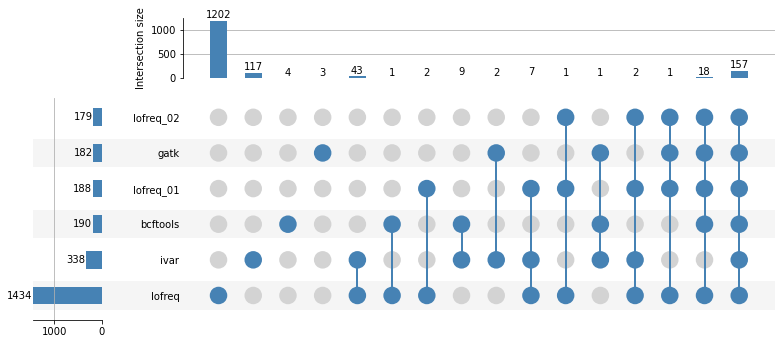

In [43]:
upset, table = plot_upset(data=all_callers, figure_name='figure_00_all_variants_upset.png')

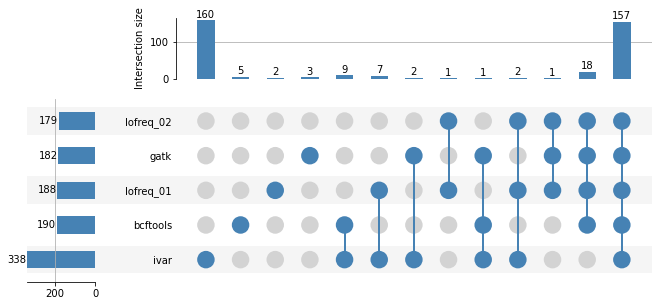

In [44]:
upset, table = plot_upset(data=all_callers[all_callers["caller"] != "lofreq"], figure_name='figure_00_all_variants_without_unfiltered_upset.png')

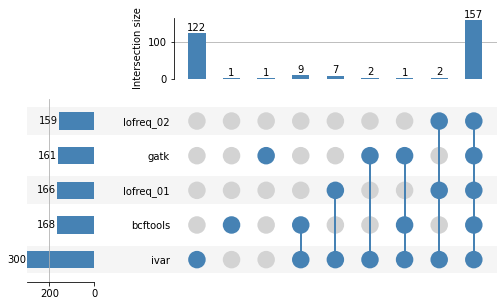

In [49]:
upset, table = plot_upset(data=all_callers[(all_callers["caller"] != "lofreq") & (all_callers.indel == False)], figure_name='figure_00_all_variants_without_unfiltered_only_snps_upset.png')

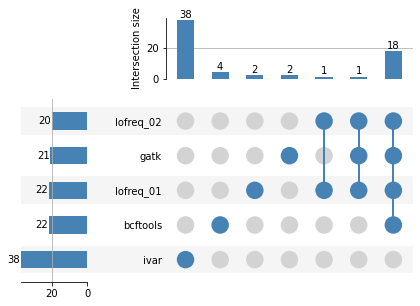

In [50]:
upset, table = plot_upset(data=all_callers[(all_callers["caller"] != "lofreq") & (all_callers.indel == True)], figure_name='figure_00_all_variants_without_unfiltered_only_indels_upset.png')